# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

In [1]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import warnings
import shutil
import zipfile
import os
import re
import seaborn as sns
import pandas as pd
import glob
import tifffile
from skimage.io import imread
warnings.filterwarnings("ignore")

/share/Users/Michael/MediumConfluency3Color_200MS_F
/share/Users/Michael/MediumConfluency3Color_100MS_F
/share/Users/Michael/MediumConfluency3Color_200MS_H
/share/Users/Michael/MediumConfluency3Color_100MS_F_Repeat

Can you do spot counting on these? and spot counting on the z projection?
They are 3 color, 15 layer zstack images on a [7 by 7] grid of positions

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

----

# Parameters defined by the user 

----

### Paths to images

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

In [4]:
### Remote directories
data_folder_path =pathlib.Path('/Users/Michael/MediumConfluency3Color_200MS_F/Full resolution')
#data_folder_path =pathlib.Path('/Users/Michael/MediumConfluency3Color_100MS_F/Full resolution')
#data_folder_path =pathlib.Path('/Users/Michael/MediumConfluency3Color_200MS_H/Full resolution')
#data_folder_path =pathlib.Path('/Users/Michael/MediumConfluency3Color_100MS_F_Repeat/Full resolution')
path_to_masks_dir = None   # full path to a zip file

In [5]:
download_data_from_NAS = True
send_data_to_NAS=False

In [6]:
# Parameters fo cell segmentation 
channels_with_cytosol =  [0,1]             # list or int indicating the channels where the cytosol is detectable
channels_with_nucleus = None          # list or int indicating the channels where the nucleus is detectable
channels_with_FISH = [0,1,2]          # list or int with the channels with FISH spots that are used for the quantification
diameter_nucleus = 200                # approximate nucleus size in pixels
diameter_cytosol = 300                # approximate cytosol size in pixels

# Parameters for FISH detection
voxel_size_z = 500    #300                      # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103 #103   #103                 # Microscope conversion px to nanometers in the xy axis.
psf_z = 350      #350                           # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx =170      #150                           # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.
#list_voxels =  [ voxel_size_z,voxel_size_yx ]
#list_psfs =  [psf_z, psf_yx ]
list_voxels = [ [ voxel_size_z,voxel_size_yx ],[ voxel_size_z,voxel_size_yx ],[ voxel_size_z,voxel_size_yx ] ]
list_psfs = [ [psf_z, psf_yx ], [psf_z, psf_yx ], [psf_z, psf_yx ] ]

# Cluster Detection
minimum_spots_cluster = 2                  # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots = False                          # Flag to display plots
optimization_segmentation_method = None    # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' ,  'center_slice', None
save_all_images = False                     # If true, it shows a all planes for the FISH plot detection. 
threshold_for_spot_detection = None       # Intensity threshold to detect  spots. If None, it will automatically detect the spots.

In [7]:
# names for final folders
if (threshold_for_spot_detection is None):
    name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) +'__cyto_' + str(diameter_cytosol) +'__psfz_' + str(psf_z) +'__psfyx_' + str(psf_yx)+'__cs_'+str(minimum_spots_cluster)+'__ts_auto' 
else:
    name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) +'__cyto_' + str(diameter_cytosol) +'__psfz_' + str(psf_z) +'__psfyx_' + str(psf_yx)+'__cs_'+str(minimum_spots_cluster)+'__ts_'+str(threshold_for_spot_detection)

## Connecting to NAS and Downloading data

In [8]:
def download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200):
    # Downloading data from NAS
    local_folder_path = pathlib.Path().absolute().joinpath('temp_' + data_folder_path.name)
    fa.NASConnection(path_to_config_file,share_name = share_name).copy_files(data_folder_path, local_folder_path,timeout=timeout)
    local_data_dir = local_folder_path     # path to a folder with images.
    # Downloading masks from NAS
    if not (path_to_masks_dir is None):
        local_folder_path_masks = pathlib.Path().absolute().joinpath( path_to_masks_dir.stem  )
        zip_file_path = local_folder_path_masks.joinpath( path_to_masks_dir.stem +'.zip')
        print(zip_file_path)
        fa.NASConnection(path_to_config_file,share_name = share_name).download_file(path_to_masks_dir, local_folder_path_masks,timeout=timeout)
        # Unzip downloaded images and update mask directory
        file_to_unzip = zipfile.ZipFile(str(zip_file_path)) # opens zip
        # Iterates for each file in zip file
        for file_in_zip in file_to_unzip.namelist():
            # Extracts data to specific folder
            file_to_unzip.extract(file_in_zip,local_folder_path_masks)
        # Closes the zip file
        file_to_unzip.close()
        # removes the original zip file
        os.remove(zip_file_path)
        masks_dir = local_folder_path_masks
    else:
        masks_dir = None
    return local_data_dir, masks_dir

In [9]:
# Download data from NAS
if download_data_from_NAS == True:
    share_name = 'share'
    local_data_dir, masks_dir= download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200)
else:
    local_data_dir = data_folder_path 
    masks_dir = path_to_masks_dir 

Connection established
File Downloaded : MediumConfluency3Color_200MS_FLI_3QuadAndRepeat_NDTiffStack.tif
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks_Michael/temp_Full resolution


In [10]:
# Detecting if images need to be merged
list_images, path_files, list_files_names, number_images = fa.ReadImages(directory= local_data_dir).read()
# Printing image properties
print('Image shape: ', list_images[0].shape , '\n')
print('Number of images: ',number_images , '\n')
print('Local directory with images: ', local_data_dir, '\n')
#del list_images
microscope_image_stack = list_images[0]    
# They are 3 color, 15 layer z-stack images on a [7 by 7] grid of positions

Image shape:  (2205, 512, 512) 

Number of images:  1 

Local directory with images:  /home/luisub/Desktop/FISH_Processing/notebooks_Michael/temp_Full resolution 



In [11]:
# creating a subdirectory to store separated images
separated_files_path = local_data_dir.joinpath('separated_images')
if not os.path.exists(str(separated_files_path)):
    os.makedirs(str(separated_files_path))
separated_files_path

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks_Michael/temp_Full resolution/separated_images')

In [12]:
# converting the data to the standard tensor.
num_z = 15
num_channels = 3
xy_size = microscope_image_stack.shape[1]
number_of_independent_fov = 49 # 7*7 grid
list_selected_z_silces = [6,7,8]  # subsection of slices to process.
process_full_stack = False # this flag indicate if the full stack is needed.


In [13]:
list_separated_images = []
for i in range(number_of_independent_fov):
    counter = 0
    temp_image = np.zeros((num_z, xy_size, xy_size, num_channels))
    for z in range(num_z): #range (number_of_independent_fov):
        for ch in range(num_channels):
            temp_image[z,:,:,ch] =  microscope_image_stack[counter] # ZYXC
            counter+=1
    #file_name_merged_image = 'image_grid_'+str(i)+'.tif'
    #tifffile.imsave(separated_files_path.joinpath(file_name_merged_image), temp_image, metadata={'axes': 'ZYXC'})
    list_separated_images.append(temp_image)
    del temp_image


In [14]:
for i in range(number_of_independent_fov):
    temp_image= list_separated_images[i][list_selected_z_silces, :,:,:]
    file_name_merged_image = 'image_grid_'+str(i)+'.tif'
    tifffile.imsave(separated_files_path.joinpath(file_name_merged_image), temp_image, metadata={'axes': 'ZYXC'})

In [15]:
# Detecting if images need to be merged
list_images, path_files, list_files_names, number_images = fa.ReadImages(directory= separated_files_path).read()
# Printing image properties
print('Image shape: ', list_images[0].shape , '\n')
print('Number of images: ',number_images , '\n')
print('Local directory with images: ', local_data_dir, '\n')
del list_images


Image shape:  (3, 512, 512, 3) 

Number of images:  49 

Local directory with images:  /home/luisub/Desktop/FISH_Processing/notebooks_Michael/temp_Full resolution 



----

## Running the pipeline

----

In [16]:
dataframe_FISH,_,_,_ = fa.PipelineFISH(separated_files_path, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  list_voxels=list_voxels, list_psfs=list_psfs, show_plots=show_plots, file_name_str =data_folder_path.name, optimization_segmentation_method = optimization_segmentation_method,save_all_images=save_all_images,threshold_for_spot_detection=threshold_for_spot_detection ).run()

 ############### 
       IMAGE : 0
 ############### 
 
ORIGINAL IMAGE
image_grid_0.tif
(3, 512, 512, 3)
CELL SEGMENTATION
No paired masks were detected for this image
SPOT DETECTION
Spot Detection for Channel : 0
sigma_value (z,y,x) = (0.7, 1.6504854368932038, 1.6504854368932038)
Int threshold used for the detection of spots:  82.0
Z-Slice:  1
Spot Detection for Channel : 1
sigma_value (z,y,x) = (0.7, 1.6504854368932038, 1.6504854368932038)
Int threshold used for the detection of spots:  141.0
Z-Slice:  1
Spot Detection for Channel : 2
sigma_value (z,y,x) = (0.7, 1.6504854368932038, 1.6504854368932038)
Int threshold used for the detection of spots:  116.0
Z-Slice:  1
 ############### 
       IMAGE : 1
 ############### 
 
ORIGINAL IMAGE
image_grid_1.tif
(3, 512, 512, 3)
CELL SEGMENTATION
No paired masks were detected for this image
SPOT DETECTION
Spot Detection for Channel : 0
sigma_value (z,y,x) = (0.7, 1.6504854368932038, 1.6504854368932038)
Int threshold used for the detection of spo

In [17]:
# create results folder
if not os.path.exists(str('analysis_'+ name_final_folder)):
    os.makedirs(str('analysis_'+ name_final_folder))    

In [18]:
def extracting_data_from_df (df,spot_type_selected=0):
    number_cells = df['cell_id'].nunique()
    # Number of spots
    number_of_spots_per_cell = [len( df.loc[  (df['cell_id']==i)  & (df['spot_type']==spot_type_selected) & (df['is_cell_fragmented']!=-1)  ].spot_id) for i in range(0, number_cells)]
    # Number of spots in cytosol
    number_of_spots_per_cell_cytosol = [len( df.loc[  (df['cell_id']==i) & (df['is_nuc']==False) & (df['spot_type']==spot_type_selected) & (df['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
    # Number of spots in nucleus
    number_of_spots_per_cell_nucleus = [len( df.loc[  (df['cell_id']==i) &  (df['is_cluster']==False) & (df['is_nuc']==True) & (df['spot_type']==spot_type_selected)  & (df['is_cell_fragmented']!=-1)   ].spot_id) for i in range(0, number_cells)]
    # Number of TS per cell.
    number_of_TS_per_cell = [len( df.loc[  (df['cell_id']==i) &  (df['is_cluster']==True) & (df['is_nuc']==True) & (df['spot_type']==spot_type_selected) & (df['cluster_size'] >=minimum_spots_cluster) & (df['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
    # Number of RNA in a TS
    ts_size =  df.loc[   (df['is_cluster']==True) & (df['is_nuc']==True)  & (df['spot_type']==spot_type_selected) & (df['is_cell_fragmented']!=-1)  ].cluster_size.values
    # Size of each cell
    cell_size = [df.loc[df['cell_id']==i].cell_area_px.values[0] for i in range(0, number_cells)]
    return number_of_spots_per_cell,number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size 

In [19]:
# Plotting intensity distributions
plt.style.use('ggplot')  # ggplot  #default
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
  n, bins, _ = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
  plt.title(title, size=16)
  return (f)

<Figure size 432x288 with 0 Axes>

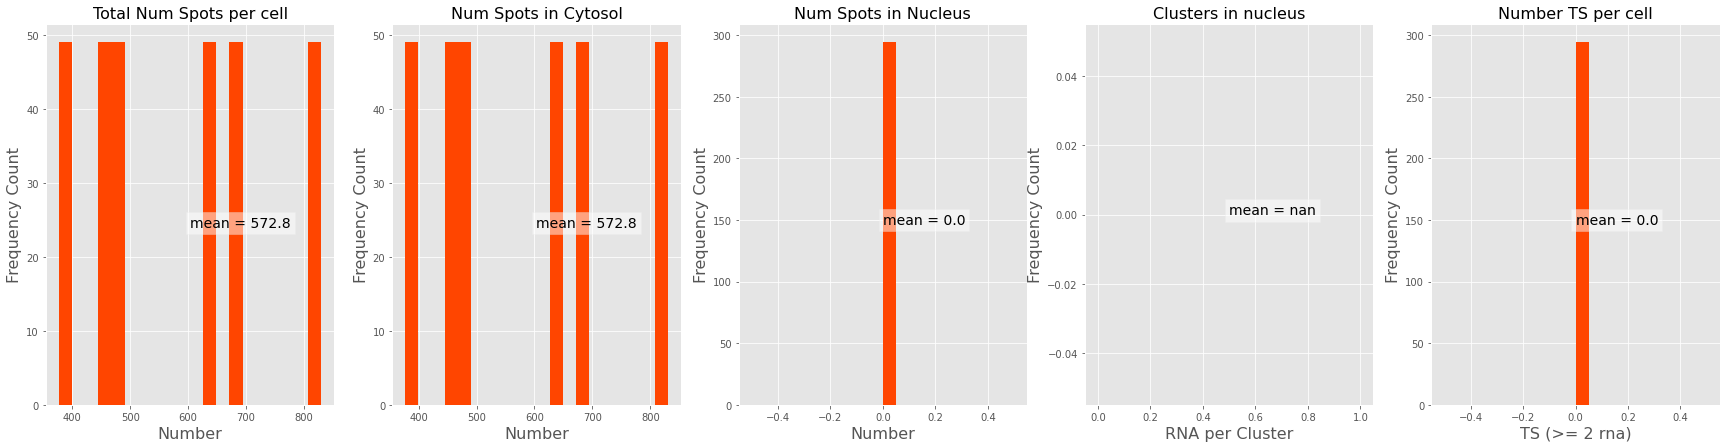

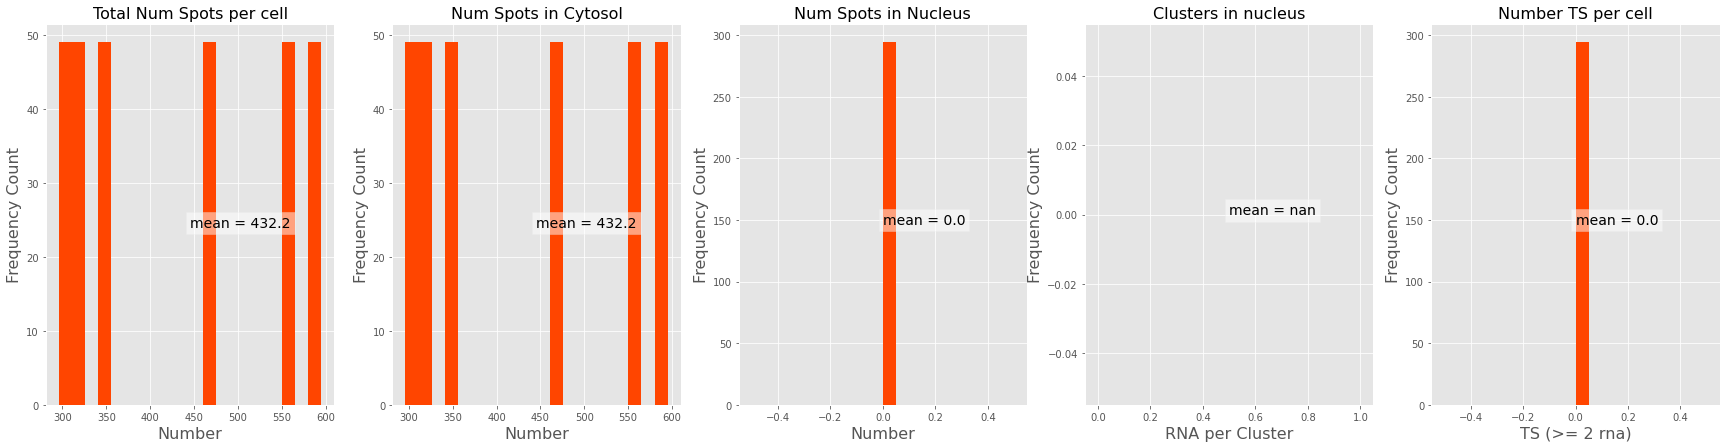

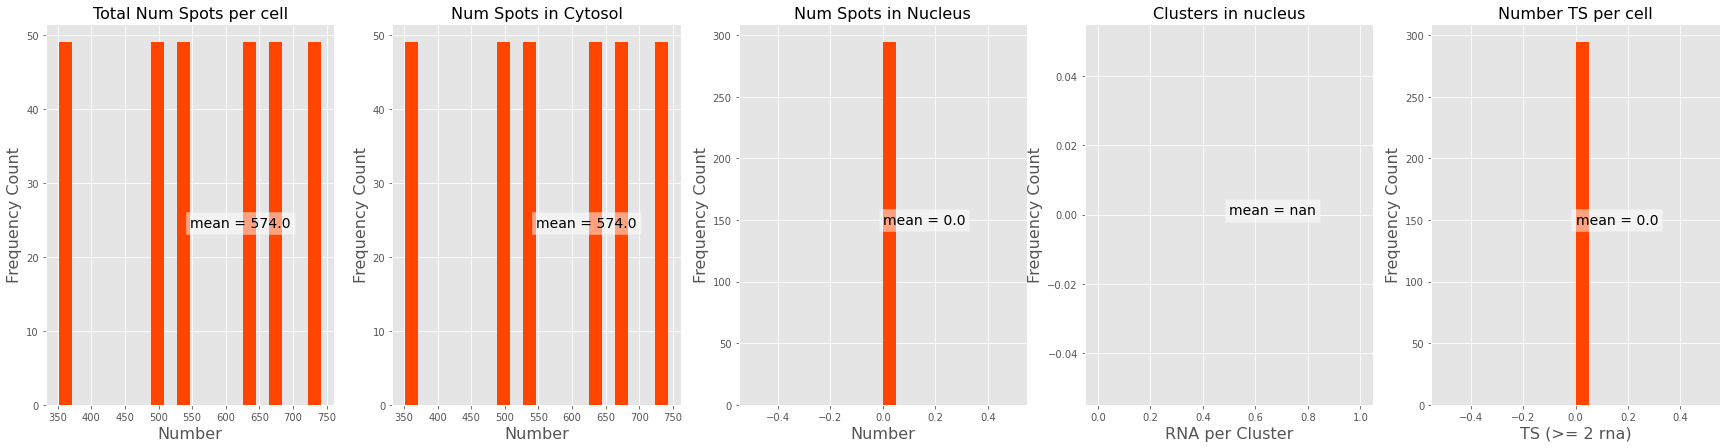

In [20]:

# Extracting data from data frame
for i, channel in enumerate(channels_with_FISH):
    number_of_spots_per_cell,number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size = extracting_data_from_df (df=dataframe_FISH,spot_type_selected=i)
    #Plotting
    fig_size = (30, 7)
    f = plt.figure(figsize=fig_size)
    ylab='Frequency Count'  
    # adding subplots
    f.add_subplot(1,5,1) 
    plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color='orangered')
    f.add_subplot(1,5,2) 
    plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color='orangered')
    f.add_subplot(1,5,3) 
    plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color='orangered')
    f.add_subplot(1,5,4) 
    plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color='orangered')
    f.add_subplot(1,5,5) 
    plot_probability_distribution(number_of_TS_per_cell ,  numBins=20, title='Number TS per cell', xlab='TS (>= '+str(minimum_spots_cluster)+' rna)', ylab=ylab, fig=f, color='orangered')
    plt.savefig('plots_'+data_folder_path.name+'__'+str(i)+'.png')
    plt.show()
    #Figure_path 
    pathlib.Path().absolute().joinpath('plots_'+ data_folder_path.name+'__'+str(i)+'.png').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'plots_'+ data_folder_path.name+'__'+str(i)+'.png'))

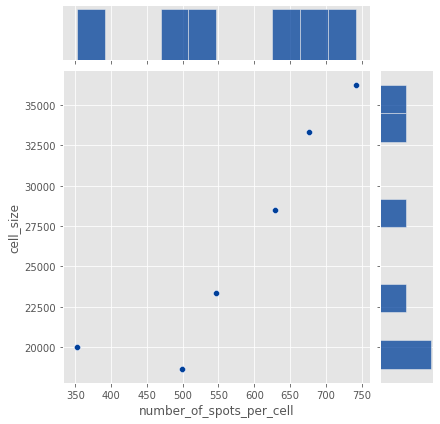

In [21]:
# Plotting Cell size vs 
df_join_distribution = pd.DataFrame({"number_of_spots_per_cell":number_of_spots_per_cell,"cell_size":cell_size})
sns.jointplot(data=df_join_distribution, x="number_of_spots_per_cell", y="cell_size",kind='scatter',color="#003f9a") #,kind='hex','resid','kde'

In [22]:

#metadata_path
pathlib.Path().absolute().joinpath('metadata_'+ data_folder_path.name +'.txt').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'metadata_'+ data_folder_path.name +'.txt'))
#dataframe_path 
pathlib.Path().absolute().joinpath('dataframe_' + data_folder_path.name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'dataframe_'+ data_folder_path.name +'.csv'))
#pdf_path 
pathlib.Path().absolute().joinpath('pdf_report_' + data_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder    ),'pdf_report_'+ data_folder_path.name +'.pdf'))

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks_Michael/analysis_Full resolution___nuc_200__cyto_300__psfz_350__psfyx_170__cs_2__ts_auto/pdf_report_Full resolution.pdf')

In [23]:
# Writing masks to NAS
if path_to_masks_dir == None: 
    mask_folder_created_by_pipeline = 'masks_'+ data_folder_path.name # default name by pipeline
    name_final_masks = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) 
    mask_dir_complete_name = 'masks_'+ name_final_masks # final name for masks dir
    shutil.move(mask_folder_created_by_pipeline, mask_dir_complete_name ) # remaing the masks dir
else: 
    mask_dir_complete_name = masks_dir.name
    
if (send_data_to_NAS == True) and (path_to_masks_dir == None) :
    shutil.make_archive( mask_dir_complete_name , 'zip', pathlib.Path().absolute().joinpath(mask_dir_complete_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip'))

In [24]:
# Writing analyses data to NAS
analysis_folder_name = 'analysis_'+ name_final_folder
if send_data_to_NAS == True:
    shutil.make_archive(analysis_folder_name,'zip',pathlib.Path().absolute().joinpath(analysis_folder_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip'))

In [25]:
# Moving all results to "analyses" folder
if not os.path.exists(str('analyses')):
    os.makedirs(str('analyses'))

# Subfolder name
final_dir_name =pathlib.Path().absolute().joinpath('analyses', analysis_folder_name)

# Removing directory if exist
if os.path.exists(str(final_dir_name)):
    shutil.rmtree(str(final_dir_name))

# Moving results to a subdirectory in 'analyses' folder
pathlib.Path().absolute().joinpath(analysis_folder_name).rename(final_dir_name )

# Moving masks to a subdirectory in 'analyses' folder
if (download_data_from_NAS == True) or (path_to_masks_dir == None):
    final_mask_dir_name = pathlib.Path().absolute().joinpath('analyses', mask_dir_complete_name)
    if os.path.exists(str(final_mask_dir_name)):
        shutil.rmtree(str(final_mask_dir_name))
    pathlib.Path().absolute().joinpath(mask_dir_complete_name).rename(final_mask_dir_name )

# Delete local temporal files
temp_results_folder_name = pathlib.Path().absolute().joinpath('temp_results_' + data_folder_path.name)
shutil.rmtree(temp_results_folder_name)

if (download_data_from_NAS == True):
    # Delete temporal images downloaded from NAS
    shutil.rmtree(local_data_dir)